# Hanks valence theory implementation

Given a list of argument pairs for a verb of valence 2, we find the clusters of semantic type and calculate its frequency.

We'll follow these steps:
1. Load the sub-obj pairs
2. Load the semantic types inventory
3. For each word (subject and object) in the sub-obj pairs find the corresponding semantic types
4. Calculate semantic types combinations and its frequencies and show the results

In [90]:
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt

import pandas as pd
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus.reader.wordnet import Synset
import spacy

nltk.download('wordnet')

spacy.cli.download("en_core_web_md")
nlp = spacy.load("en_core_web_md")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gianl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### 1. Load the sub-obj pairs

In [91]:
df = pd.read_csv('res/see_sub_obj_pairs.csv')
df.head()

,subject,object
0,Republicans,it
1,You,signs
2,Democrats,opportunity
3,which,soldiers
4,they,approach


### 2. Load the semantic types inventory

In [92]:
# holds a mapping (wordnet id, wordnet pos) -> semantic type
wn_semantic_type_dict: Dict[Tuple[int, str], str] = {}

# open semantic types inventory
with open('res/st_inventory.txt', 'r') as f:
    # shorter version
    # wn_semantic_type_dict = {line.split('\t')[0]: line.split('\t')[1] for line in f.read().splitlines()[:10]}
    
    st_inventory = f.read().splitlines()
    # each line is of the form: wn:08641944n\tGEOGRAPHY_AND_PLACES_
    for line in st_inventory:
        l = line.split('\t')
        wn_id = l[0]
        # separate id in the form wn:08641944n to [08641944, n] (synset offset, pos tag)
        wn_id_number, wn_id_pos = int(wn_id[3:-1]), wn_id[-1]
        semantic_type = l[1]
        wn_semantic_type_dict[(wn_id_number, wn_id_pos)] = semantic_type 

In [93]:
# print first 10 entries
for i, (wn_id, st) in enumerate(wn_semantic_type_dict.items()):
    print(wn_id, st)
    if i == 10:
        break

(8641944, 'n') GEOGRAPHY_AND_PLACES_
(8950407, 'n') GEOGRAPHY_AND_PLACES_
(4502851, 'n') WARFARE_DEFENSE_AND_VIOLENCE_
(13742358, 'n') MATHEMATICS_
(13742573, 'n') MATHEMATICS_
(14930670, 'n') CHEMISTRY_AND_MINERALOGY_
(475142, 'n') SPORT_GAMES_AND_RECREATION_
(13746512, 'n') MATHEMATICS_
(13750415, 'n') MATHEMATICS_
(13750844, 'n') MATHEMATICS_
(13751265, 'n') MATHEMATICS_


### 3. For each word (subject and object) in the sub-obj pairs find the corresponding semantic types

In [94]:
def get_synset_from_id(wn_id: Tuple[int, str]) -> Synset:
    """
    Given a wordnet id (offset, pos), return the corresponding synset
    :param wn_id: wordnet id in the form (offset, pos)
    :return: synset corresponding to the wordnet id
    """
    return wn.synset_from_pos_and_offset(wn_id[1], wn_id[0])

In [95]:
# print first 10 synsets
for wn_id in list(wn_semantic_type_dict.keys())[:10]:
    print(get_synset_from_id(wn_id))

Synset(''hood.n.01')
Synset('the_hague.n.01')
Synset('twenty-two.n.02')
Synset('zero.n.02')
Synset('one.n.01')
Synset('lauryl_alcohol.n.01')
Synset('one-hitter.n.01')
Synset('ten.n.01')
Synset('hundred.n.01')
Synset('thousand.n.01')


Create a list of available synsets from st_inventory and a list of pronouns to be used later.

In [96]:
# save list of synsets available
synset_list: List[Synset] = []

for wn_id in list(wn_semantic_type_dict.keys()):
    synset_list.append(get_synset_from_id(wn_id))
    
# save list of pronouns, to be used later
living_entity_pronouns = ["I", "you", "he", "she", "we", "they", "me", "you", "him", "her", "us", "them"]
object_pronouns = ["it"]

#### Functions to retrieve semantic types for a word based on its type (pronoun, common noun, named entity)

Depending on the type of the word (pronoun, common noun, named entity), we'll retrieve the semantic types by calling the right function.

In [97]:
lemmatizer = nltk.WordNetLemmatizer()

def get_common_nouns_sem_types(word: str) -> List[str]:
    """
    Given a word, expected to be a common noun, retrieve all the synsets from st_inventory where the word is included, and return the corresponding semantic types
    """
    sem_types = []
    
    for synset in synset_list: # iterate synsets in st_inventory
        if word in synset.lemma_names(): # if the word is in the synset
            # get the sem type from st_inventory corresponding to the synset associated to the word (identified by offset, pos)
            sem_type = wn_semantic_type_dict[(synset.offset(), synset.pos())]
            sem_types.append(sem_type)
    
    return sem_types

In [98]:
def get_pronoun_sem_types(pronoun: str) -> List[str]:
    """
    Given a pronoun, return the semantic types of the pronoun
    """
    if pronoun in living_entity_pronouns:
        return ["LIVING_ENTITY_"]
    elif pronoun in object_pronouns:
        return ["OBJECT_"]

In [99]:
def ner_single_word(word: str)-> List[Tuple[str, str]]:
    doc = nlp(word)
    # return the entity type if available
    return [(ent.text, ent.label_) for ent in doc.ents]

def get_named_entity_sem_types(named_entities: List[str]) -> List[str]:
    """
    Given a named entity, return the semantic types of the named entity
    """
    # retrieve the entity type if available
    for ent in named_entities:
        # we now consider only the first entity type
        sem_type = ent[1]
        if sem_type == "ORG":
            return ["ORGANIZATION_"]
        elif sem_type == "GPE":
            return ["GEOGRAPHY_AND_PLACES_"]
        elif sem_type == "NORP":
            return ["NATIONALITIES_OR_RELIGIONS_OR_POLITICAL_GROUPS_"]
        else:
            return [sem_type]

Function to select the n most frequent semantic types for each word

In [100]:
def select_most_freq_sem_type(sem_types: List[str], n: int) -> List[str]:
    """
    Given a list of semantic types as strings, select the n most frequent semantic types
    :param sem_types: list of semantic types as strings
    :param n: number of most frequent semantic types to select
    :return: list of n most frequent semantic types
    """
    sem_type_freq = {}
    
    for sem_type in sem_types:
        if sem_type in sem_type_freq:
            sem_type_freq[sem_type] += 1
        else:
            sem_type_freq[sem_type] = 1
    
    # sort the semantic types by frequency, uses the frequency as the key
    sorted_sem_type_freq = sorted(sem_type_freq.items(), key=lambda x: x[1], reverse=True)
    # take the first n semantic types from the sorted list
    return [sem_type for sem_type, freq in sorted_sem_type_freq[:n]]

Run the right functions to get the semantic types for a word based on its type (pronoun, common noun, named entity)

In [101]:
word_sem_type_dict: Dict[str, List[str]] = {} # dictionary to store the semantic types of each word (word -> semantic types)
unkonwn_words = set() # set to store unknown words (words for which we couldn't find semantic types)

def find_sem_types(word: str, n_most_freq: int = 2 ):
    """
    Given a word, find the n_most_freq most frequent semantic types for the word based on its type (pronoun, common noun, named entity) and store them in the word_sem_type_dict
    :param word: word to find the semantic types
    :param n_most_freq: number of most frequent semantic types to select
    """
    lemmatized_word = lemmatizer.lemmatize(word)

    if word not in word_sem_type_dict: # if the word is not already in the dictionary
        # extract possible named entities
        named_entities = ner_single_word(word)
        
        if word.lower() in living_entity_pronouns + object_pronouns: # if the word is a pronoun
            sem_types = get_pronoun_sem_types(word.lower())
        elif named_entities: # if the word is a named entity
            sem_types = get_named_entity_sem_types(named_entities)
        else: # if the word is a common noun
            sem_types = get_common_nouns_sem_types(lemmatized_word)
        
        if sem_types: # if we found semantic types
            frequent_sem_types = select_most_freq_sem_type(sem_types, n_most_freq) # get most frequent semantic types
            word_sem_type_dict[word] = frequent_sem_types # store the semantic types in the dictionary
        else:
            unkonwn_words.add(word)

For each word in the sub-obj pairs, find the corresponding `n_most_freq` most frequent semantic types

In [102]:
for i, row in df.iterrows():
    sub: str = row['subject']
    obj: str = row['object']
    n_most_freq = 2 # number of most frequent semantic types to select
        
    find_sem_types(sub, n_most_freq)
    find_sem_types(obj, n_most_freq)

In [103]:
# print first 10 entries (word, semantic types)
for i, (word, synsets) in enumerate(word_sem_type_dict.items()):
    print(word, synsets)
    if i == 10:
        break

Republicans ['NATIONALITIES_OR_RELIGIONS_OR_POLITICAL_GROUPS_']
it ['OBJECT_']
You ['LIVING_ENTITY_']
signs ['LANGUAGE_AND_LINGUISTICS_', 'RELIGION_MYSTICISM_AND_MYTHOLOGY_']
Democrats ['NATIONALITIES_OR_RELIGIONS_OR_POLITICAL_GROUPS_']
opportunity ['GENERAL_']
soldiers ['WARFARE_DEFENSE_AND_VIOLENCE_', 'BIOLOGY_']
they ['LIVING_ENTITY_']
approach ['SEX_', 'PHILOSOPHY_PSYCHOLOGY_AND_BEHAVIOR_']
year ['HISTORY_', 'TIME_']
cleaning ['CULTURE_ANTHROPOLOGY_AND_SOCIETY_']


### 4. Calculate semantic types combinations and its frequencies

Calculate all possible combinations of semantic types (collocation) from the sub-obj pairs and store the number of occurrences.

In [104]:
sem_type_combinations: Dict[Tuple[str, str], int] = {} # dictionary to store the frequency of each combination of semantic types
for i, row in df.iterrows():
    sub: str = row['subject']
    obj: str = row['object']
    
    # if the subject or object is an unknown word, skip, because we don't have the semantic types and the sentence is not useful
    if sub in unkonwn_words or obj in unkonwn_words:
        continue
    
    # get the semantic types of the subject and object
    sub_sem_types: List[str] = word_sem_type_dict[sub]
    obj_sem_types: List[str] = word_sem_type_dict[obj]
    
    # for each combination of semantic types, count the number of occurrences
    for sub_sem_type in sub_sem_types:
        for obj_sem_type in obj_sem_types:
            key = (sub_sem_type, obj_sem_type)
            if key in sem_type_combinations:
                sem_type_combinations[key] += 1
            else:
                sem_type_combinations[key] = 1

Sort the semantic type combinations by frequency

In [105]:
sorted_sem_type_combinations = dict(sorted(sem_type_combinations.items(), key=lambda x: x[1], reverse=True))

Print the first 10 most frequent combinations of semantic types

In [106]:
for i, (sem_type_comb, freq) in enumerate(sorted_sem_type_combinations.items()):
    print(sem_type_comb, freq)
    if i == 10:
        break

('LIVING_ENTITY_', 'LIVING_ENTITY_') 38
('MATHEMATICS_', 'LIVING_ENTITY_') 28
('CHEMISTRY_AND_MINERALOGY_', 'LIVING_ENTITY_') 28
('LIVING_ENTITY_', 'GENERAL_') 25
('LIVING_ENTITY_', 'BIOLOGY_') 23
('LIVING_ENTITY_', 'PHILOSOPHY_PSYCHOLOGY_AND_BEHAVIOR_') 19
('LIVING_ENTITY_', 'MATHEMATICS_') 19
('LIVING_ENTITY_', 'OBJECT_') 16
('LIVING_ENTITY_', 'SPACE_AND_TOUCH_') 14
('LIVING_ENTITY_', 'CULTURE_ANTHROPOLOGY_AND_SOCIETY_') 14
('MATHEMATICS_', 'SPACE_AND_TOUCH_') 12


Plot the 10 most frequent combinations of semantic types

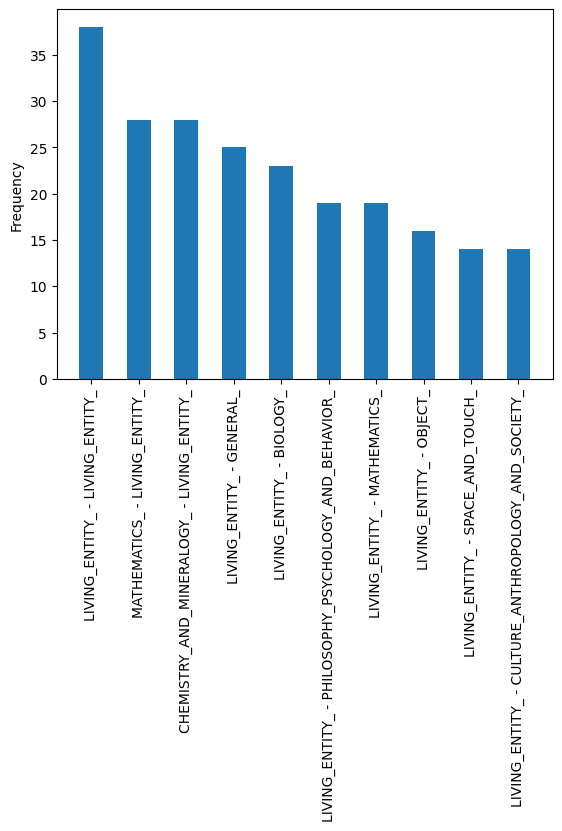

In [107]:
plt.bar(range(10), list(sorted_sem_type_combinations.values())[:10], align='center', width=0.5)
# plot vertical labels for each combination
plt.xticks(range(10), [f"{sem_type_comb[0]} - {sem_type_comb[1]}" for sem_type_comb in list(sorted_sem_type_combinations.keys())[:10]], rotation='vertical')
plt.ylabel('Frequency')
plt.show()

### --------------- old code ---------------

Calculate the probability distribution over the semantic type clusters.
For each semantic type combination, calculate the probability as the frequency of the combination divided by the total number of combinations occurrences

In [108]:
total_occurrences = sum(sem_type_combinations.values())

sem_type_probabilities = {sem_type_comb: comb_freq / total_occurrences for sem_type_comb, comb_freq in sem_type_combinations.items()}
for sem_type, prob in sem_type_probabilities.items():
    print(sem_type, prob)

('NATIONALITIES_OR_RELIGIONS_OR_POLITICAL_GROUPS_', 'OBJECT_') 0.001314060446780552
('LIVING_ENTITY_', 'LANGUAGE_AND_LINGUISTICS_') 0.01445466491458607
('LIVING_ENTITY_', 'RELIGION_MYSTICISM_AND_MYTHOLOGY_') 0.010512483574244415
('NATIONALITIES_OR_RELIGIONS_OR_POLITICAL_GROUPS_', 'GENERAL_') 0.003942181340341655
('LIVING_ENTITY_', 'SEX_') 0.001314060446780552
('LIVING_ENTITY_', 'PHILOSOPHY_PSYCHOLOGY_AND_BEHAVIOR_') 0.024967148488830485
('HISTORY_', 'CULTURE_ANTHROPOLOGY_AND_SOCIETY_') 0.001314060446780552
('TIME_', 'CULTURE_ANTHROPOLOGY_AND_SOCIETY_') 0.001314060446780552
('LIVING_ENTITY_', 'MEDIA_') 0.003942181340341655
('BUSINESS_ECONOMICS_AND_FINANCE_', 'MEDIA_') 0.001314060446780552
('BUSINESS_ECONOMICS_AND_FINANCE_', 'VISUAL_') 0.001314060446780552
('MUSIC_SOUND_AND_DANCING_', 'MEDIA_') 0.001314060446780552
('MUSIC_SOUND_AND_DANCING_', 'VISUAL_') 0.001314060446780552
('MATHEMATICS_', 'OBJECT_') 0.009198423127463863
('CHEMISTRY_AND_MINERALOGY_', 'OBJECT_') 0.009198423127463863
('P

Get the 10 most likely semantic type clusters (semantic type combinations)

In [109]:
most_likely_sem_type_clusters = dict(sorted(sem_type_probabilities.items(), key=lambda x: x[1], reverse=True))

Plot the probability distribution of most likely semantic type clusters

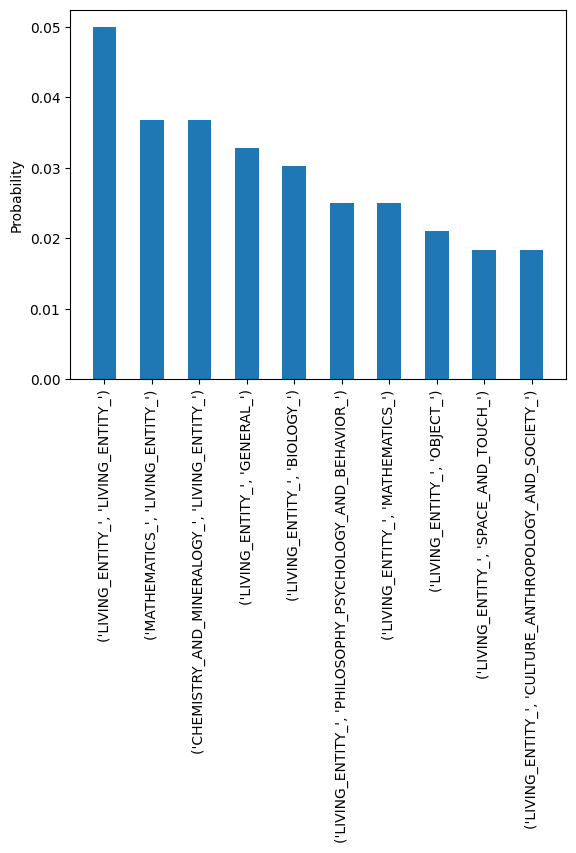

In [110]:
plt.bar(range(10), list(most_likely_sem_type_clusters.values())[:10], align='center', width=0.5)
plt.xticks(range(10), list(most_likely_sem_type_clusters.keys())[:10], rotation='vertical')
plt.ylabel('Probability')
plt.show()